## Estudio de viabilidad para el control de existencias mediante reconocimiento visual y redes neuronales convolucionales

## Deteccion y recuento de frutas

In [2]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import csv
from datetime import date, datetime

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops
# This is needed to display the images.
%matplotlib inline
#Object detections imports
from utils import label_map_util
from utils import visualization_utils as vis_util
# What model to download.
MODEL_NAME = 'mft_fr101'
#MODEL_FILE = MODEL_NAME + '.tar.gz'
#DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training_101', 'labelmap.pbtxt')
#Load a (frozen) Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
#Loadin Label maps map indices to category names, so that when our convolution network predicts 5, 
#we know that this corresponds to airplane.
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
#Helper Code
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

{'pineapple': 1, 'orange': 1}


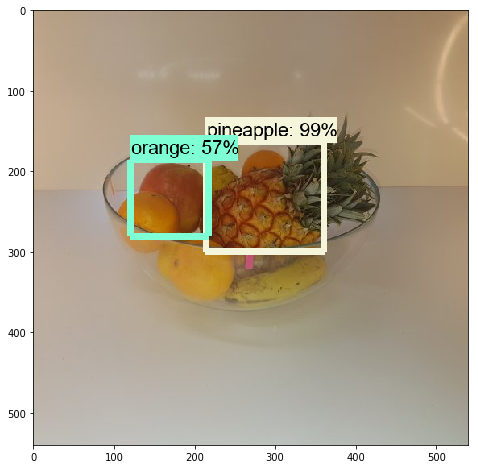

{}


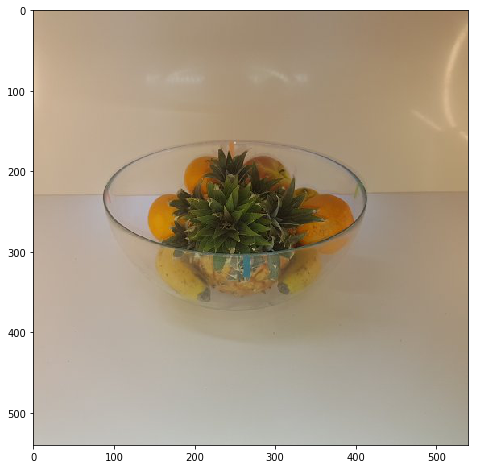

{'apple': 1, 'pineapple': 1, 'orange': 1}


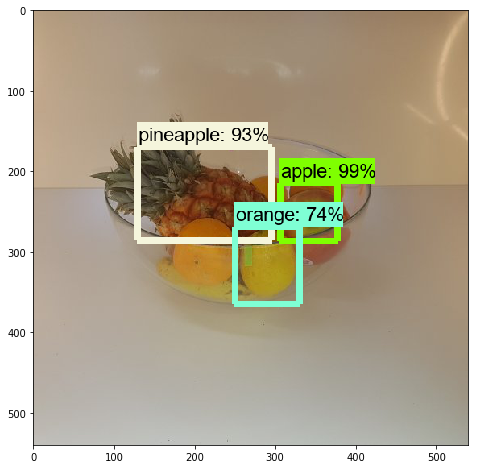

{'pineapple': 1, 'orange': 1}


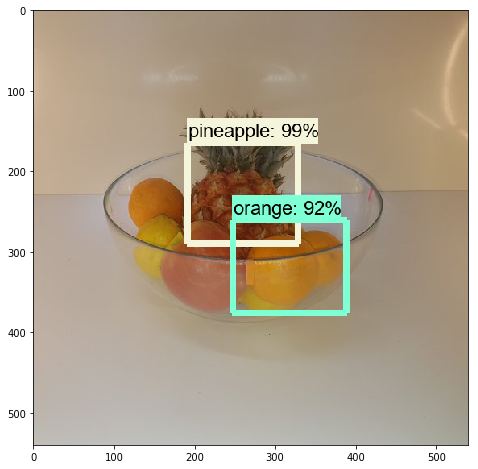

{'pineapple': 1, 'orange': 3, 'apple': 1}


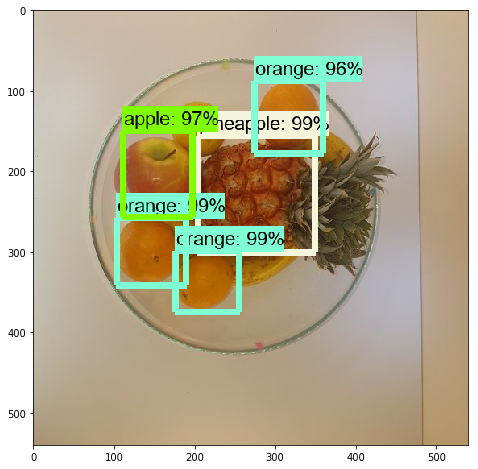

In [8]:
# Ruta a las imagnes de producción. Modificar el dia para la deteccion de imágenes
PATH_TO_TEST_IMAGES_DIR = 'test_images/D30'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 6) ]
# Size, in inches, of the output images.
IMAGE_SIZE = (10, 8)
# Eliminamos el fichero temporal si existe y lo creamos de nuevo para recibir los datos de las detección 
# de objetos y recuento de las diferentes imágenes que se tomen en la siguiente captura.
os.remove('../temporal.csv')
primera_linea=["data"]
with open("../temporal.csv", "a") as ficherocsv:
    temporal = csv.writer(ficherocsv,lineterminator="\n")
    temporal.writerow(primera_linea)
    
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  plt.show()

## Comienzo del código del sistema logístico basado en el detector

In [3]:
import ast 
import pandas as pd
import numpy as np
import datetime as dt
pd.set_option('precision', 0)
#Leemos el fichero temporal.csv con la información de las detecciones del dia
df = pd.read_csv('../temporal.csv')
tmp_df = pd.DataFrame([ast.literal_eval(i) for i in df.data.values]) 
tmp_df= tmp_df.fillna(0)
# Mostramos el recuento de las diferentes clases en las diferentes capturas realizadas sobre el frutero
tmp_df

,apple,orange,pineapple
0,0,1,1
1,0,0,0
2,1,1,1
3,0,1,1
4,1,3,1


In [10]:
# Obtenemos el valor maximo obtenido para cada una de las clases de frutas
tmp_df = tmp_df.max(axis=0)

In [11]:
#Los recuentos maximos para cada clase de fruta son:
tmp_df

apple        1
orange       3
pineapple    1
dtype: float64

In [12]:
#Inicializamos con valores a cero un nuevo diccionario para una nueva linea de recuento
recuento ={'apple':0,'pear':0,'lemon':0,'orange':0,'banana':0,'pineapple':0}

In [13]:
#Comprobamos primero que existe la clase de fruta en el recuento.
#Una vez comprobado, se añade al recuento final diario para guardarlo en el histórico.
    if 'apple' in tmp_df:
         recuento['apple']+=tmp_df.apple
    if 'pear' in tmp_df:
        recuento['pear']+=tmp_df.pear
    if 'lemon' in tmp_df:
        recuento['lemon']+=tmp_df.lemon
    if 'orange' in tmp_df:
        recuento['orange']+=tmp_df.orange
    if 'banana' in tmp_df:
        recuento['banana']+=tmp_df.banana
    if 'pineapple' in tmp_df:
        recuento['pineapple']+=tmp_df.pineapple

In [14]:
#Del ultimo recuento, los maximos valores por cada clase:
print(recuento)

{'apple': 1.0, 'pear': 0, 'lemon': 0, 'orange': 3.0, 'banana': 0, 'pineapple': 1.0}


In [15]:
#Si debido a un error se han detectado un número mayor al número de recuento máximo por clase. 
#El sistema supone que, en ese caso, existe en el frutero el recuento máximo para esa clase.
    if recuento['apple']>3:
         recuento['apple']=3
    if recuento['pear']>3:
        recuento['pear']
    if recuento['lemon']>3:
        recuento['lemon']=3
    if recuento['orange']>3:
        recuento['orange']=3
    if recuento['banana']>3:
        recuento['banana']=3
    if recuento['pineapple']>1:
        recuento['pineapple']=1

In [17]:
#Se añade la fecha actual al recuento final y guardamos los datos en una nueva linea del fichero histórico.
recuento['Fecha'] = datetime.now().strftime("%Y-%m-%d")
print(recuento)
with open("../historico_detectado.csv", "a") as pedidocsv:
    nueva_captura = csv.writer(pedidocsv, delimiter=",", lineterminator="\n")
    nueva_captura.writerow([recuento])

{'apple': 1.0, 'pear': 0, 'lemon': 0, 'orange': 3.0, 'banana': 0, 'pineapple': 1.0, 'Fecha': '2018-10-30'}


In [18]:
pd.set_option('precision', 0)
#Leemos el fichero historico.csv 
df = pd.read_csv('../historico_detectado.csv')
hist_df = pd.DataFrame([ast.literal_eval(i) for i in df.data.values]) 
hist_df= hist_df.fillna(0)
hist_df.head()

,Fecha,apple,banana,lemon,orange,pear,pineapple
0,2018-10-01,2,0,2,3,0,0
1,2018-10-02,0,1,2,2,1,0
2,2018-10-03,2,2,2,2,0,0
3,2018-10-04,2,1,3,1,0,0
4,2018-10-05,3,1,2,1,1,0


In [19]:
# Convertimos la fecha para que haga de indice
hist_df.Fecha = pd.to_datetime(hist_df.Fecha)
hist_df.set_index('Fecha', inplace=True)

In [20]:
#Diferencias entre los valores de recuento de un dia y el anterior por clases. Ultimos valores obtenidos.
hist_df.diff().tail(3)

,apple,banana,lemon,orange,pear,pineapple
Fecha,,,,,,
2018-10-28,-2,-1,1,-1,2,-1
2018-10-29,0,0,0,-1,-2,0
2018-10-30,1,-1,-1,3,0,1


In [21]:
# Media de los valores negativos entre las diferencias de un dia y el anterior. 
# Lo que significa consumo medio diario de una clase de fruta. Se cambian los valores a positivos.
dif_df =hist_df.diff()
consumo_medio= dif_df[dif_df < 0].mean()*-1
consumo_medio

apple        2
banana       1
lemon        1
orange       1
pear         1
pineapple    1
dtype: float64

In [22]:
#Las capturas y recuentos de frutas de hoy y de ayer
ayer_hoy =hist_df.tail(2)
print(ayer_hoy)

            apple  banana  lemon  orange  pear  pineapple
Fecha                                                    
2018-10-29      0       1      1       0     0          0
2018-10-30      1       0      0       3     0          1


In [23]:
# Diferencia entre la captura y recuento de frutas de hoy y el de ayer
dif_ayer_hoy = ayer_hoy.diff().tail(1).mean()
#De ayer a hoy se han consumido (valores negativos)
#De ayer a hoy se han añadido (valores positivos)
dif_ayer_hoy

apple        1
banana      -1
lemon       -1
orange       3
pear         0
pineapple    1
dtype: float64

In [24]:
# Se lee el fichero de pedidos
pf= pd.read_csv('../pedidos.csv')
ped_df = pd.DataFrame([ast.literal_eval(i) for i in pf.data.values]) 
ped_df= ped_df.fillna(0)
# Ultima linea de pedido del fichero
ult_linea_pedido_ayer= ped_df.tail(1)
print('El pedido de ayer fue...')
ult_linea_pedido_ayer

El pedido de ayer fue...


,Fecha,apple,banana,lemon,orange,pear,pineapple
28,2018-10-29,3,0,0,0,0,1


In [25]:
dif_mas_ult_pedido = dif_ayer_hoy + ult_linea_pedido_ayer
dif_mas_ult_pedido

,Fecha,apple,banana,lemon,orange,pear,pineapple
28,NaN,4,-1,-1,3,,2


In [26]:
#Se compara la diferencia entre el consumo medio y la diferenecia de valores entre hoy y ayer + pedido de ayer
i=0
for i in range(0,6):  
    if consumo_medio[i] > dif_mas_ult_pedido.values[0,i+1]:
        print("Clase de Fruta: " + dif_mas_ult_pedido.columns.values[i+1])
        print("Media de consumo: "+ str(round(consumo_medio[i],2)))
        print("El ultimo pedido contabilizado: "+ str(ult_linea_pedido_ayer.values[0,i+1]))
        print("Diferencia entre el recuento de ayer y hoy más el pedido: "+ str(dif_mas_ult_pedido.values[0,i+1]))
        print("La media de consumo es mayor a la diferencia entre el recuento de ayer y hoy más el pedido")
        print("Probabilidad de que existan "+dif_mas_ult_pedido.columns.values[i+1]+" no detectadas en el frutero")
        print("---------------------")
        i=i+1
    else:
        print("Clase de Fruta: " + dif_mas_ult_pedido.columns.values[i+1])
        print("Media de consumo: "+ str(round(consumo_medio[i],2)))
        print("El ultimo pedido contabilizado: "+ str(ult_linea_pedido_ayer.values[0,i+1]))
        print("Diferencia entre el recuento de ayer y hoy más el pedido: "+ str(dif_mas_ult_pedido.values[0,i+1]))
        print("La media de consumo es menor a la diferencia entre el recuento de ayer y hoy más el pedido")
        print("Los datos parecen estar bien")
        print("---------------------")
        i=i+1

Clase de Fruta: apple
Media de consumo: 1.55
El ultimo pedido contabilizado: 3
Diferencia entre el recuento de ayer y hoy más el pedido: 4.0
La media de consumo es menor a la diferencia entre el recuento de ayer y hoy más el pedido
Los datos parecen estar bien
---------------------
Clase de Fruta: banana
Media de consumo: 1.44
El ultimo pedido contabilizado: 0
Diferencia entre el recuento de ayer y hoy más el pedido: -1.0
La media de consumo es mayor a la diferencia entre el recuento de ayer y hoy más el pedido
Probabilidad de que existan banana no detectadas en el frutero
---------------------
Clase de Fruta: lemon
Media de consumo: 1.42
El ultimo pedido contabilizado: 0
Diferencia entre el recuento de ayer y hoy más el pedido: -1.0
La media de consumo es mayor a la diferencia entre el recuento de ayer y hoy más el pedido
Probabilidad de que existan lemon no detectadas en el frutero
---------------------
Clase de Fruta: orange
Media de consumo: 1.2
El ultimo pedido contabilizado: 0
Di

In [27]:
#Inicializamos con valores a cero un nuevo diccionario para una nueva linea de pedido si hiciera falta.
pedidos ={'apple':0,'pear':0,'lemon':0,'orange':0,'banana':0,'pineapple':0}

In [28]:
last=hist_df.tail(1)
print(last)

            apple  banana  lemon  orange  pear  pineapple
Fecha                                                    
2018-10-30      1       0      0       3     0          1


In [29]:
i=0
for i in range(0,6):  
    if last.values[0,i]==0 and last.columns.values[i] == 'pineapple':
        print("No queda: "+last.columns.values[i]+". Añadir a linea de pedido 1 unidad:")
        pedidos[last.columns.values[i]]+=1
    elif last.values[0,i]==0 and last.columns.values[i] != 'pineapple':
        print("No queda: "+last.columns.values[i]+". Añadir a linea de pedido 3 unidades:")
        pedidos[last.columns.values[i]]+=3

No queda: banana. Añadir a linea de pedido 3 unidades:
No queda: lemon. Añadir a linea de pedido 3 unidades:
No queda: pear. Añadir a linea de pedido 3 unidades:


In [30]:
print(pedidos)

{'apple': 0, 'pear': 3, 'lemon': 3, 'orange': 0, 'banana': 3, 'pineapple': 0}


In [31]:
#Guardamos la nueva linea de pedido en el fichero "pedidos.csv"
pedidos['Fecha'] = datetime.now().strftime("%Y-%m-%d")
print(pedidos)
with open("../pedidos.csv", "a") as pedidocsv:
    linea_pedido = csv.writer(pedidocsv, delimiter=",", lineterminator="\n")
    linea_pedido.writerow([pedidos])

{'apple': 0, 'pear': 3, 'lemon': 3, 'orange': 0, 'banana': 3, 'pineapple': 0, 'Fecha': '2018-10-30'}


## Matrices de confusión

In [4]:
pd.set_option('precision', 0)
#Se guarda en un dataframe los valores contenidos en el fichero historico_detectado.csv
df1 = pd.read_csv('../historico_detectado.csv')
hist_d = pd.DataFrame([ast.literal_eval(i) for i in df1.data.values]) 
hist_d= hist_d.fillna(0)

In [5]:
#Se guarda en un dataframe los valores contenidos en el fichero historico_real.csv
df2 = pd.read_csv('../historico_real.csv')
hist_r = pd.DataFrame([ast.literal_eval(i) for i in df2.data.values]) 
hist_r= hist_r.fillna(0)

In [6]:
hist_d=hist_d[:30]
hist_r=hist_r[:30]

In [8]:
# Se importa la libreria ConfusionMAtrix de pandas_ML para ejecutar las matrices de confusión
import pandas_ml as pdml
from pandas_ml import ConfusionMatrix
# Matriz de confusión para la clase apple.Se enfrentan los valores detectados contra los valores reales
cm_a = ConfusionMatrix(hist_d.apple,hist_r.apple)
cm_a.print_stats()

Confusion Matrix:

Predicted  0  1  2   3  __all__
Actual                         
0          8  0  1   0        9
1          0  6  1   3       10
2          0  0  3   6        9
3          0  0  0   2        2
__all__    8  6  5  11       30


Overall Statistics:

Accuracy: 0.6333333333333333
95% CI: (0.4385598490119576, 0.8007013749879655)
No Information Rate: ToDo
P-Value [Acc > NIR]: 0.002706862487690975
Kappa: 0.5292439372325249
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                   0    1    2     3
Population                               30   30   30    30
P: Condition positive                     9   10    9     2
N: Condition negative                    21   20   21    28
Test outcome positive                     8    6    5    11
Test outcome negative                    22   24   25    19
TP: True Positive                         8    6    3     2
TN: True Negative                        21   20   19    19
FP: False Positive              

In [13]:
cm_a2 = ConfusionMatrix(hist_d.orange,hist_r.orange)
cm_a2.print_stats()

Confusion Matrix:

Predicted  0  1  2   3  __all__
Actual                         
0          3  3  2   1        9
1          1  5  3   1       10
2          0  0  3   5        8
3          0  0  0   3        3
__all__    4  8  8  10       30


Overall Statistics:

Accuracy: 0.4666666666666667
95% CI: (0.2834180791835371, 0.6567447618392659)
No Information Rate: ToDo
P-Value [Acc > NIR]: 0.08977091541745619
Kappa: 0.30434782608695654
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                    0    1    2    3
Population                                30   30   30   30
P: Condition positive                      9   10    8    3
N: Condition negative                     21   20   22   27
Test outcome positive                      4    8    8   10
Test outcome negative                     26   22   22   20
TP: True Positive                          3    5    3    3
TN: True Negative                         20   17   17   20
FP: False Positive              

In [14]:
cm_a3 = ConfusionMatrix(hist_d.pear,hist_r.pear)
cm_a3.print_stats()

Confusion Matrix:

Predicted   0  1  2  3  __all__
Actual                         
0           8  1  3  1       13
1           3  4  4  3       14
2           0  0  0  3        3
3           0  0  0  0        0
__all__    11  5  7  7       30


Overall Statistics:

Accuracy: 0.4
95% CI: (0.22655764882859367, 0.5939650699481813)
No Information Rate: ToDo
P-Value [Acc > NIR]: 0.4186487780542035
Kappa: 0.1891891891891892
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                  0     1    2    3
Population                              30    30   30   30
P: Condition positive                   13    14    3    0
N: Condition negative                   17    16   27   30
Test outcome positive                   11     5    7    7
Test outcome negative                   19    25   23   23
TP: True Positive                        8     4    0    0
TN: True Negative                       14    15   20   23
FP: False Positive                       3     1    7   

In [11]:
cm_a4 = ConfusionMatrix(hist_d.banana,hist_r.banana)
cm_a4.print_stats()

Confusion Matrix:

Predicted  0  1  2  3  __all__
Actual                        
0          3  1  2  1        7
1          4  4  4  3       15
2          0  0  2  4        6
3          0  0  1  1        2
__all__    7  5  9  9       30


Overall Statistics:

Accuracy: 0.3333333333333333
95% CI: (0.17287422152603915, 0.5281200447898805)
No Information Rate: ToDo
P-Value [Acc > NIR]: 0.4111913147592773
Kappa: 0.1477272727272727
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                  0     1     2     3
Population                              30    30    30    30
P: Condition positive                    7    15     6     2
N: Condition negative                   23    15    24    28
Test outcome positive                    7     5     9     9
Test outcome negative                   23    25    21    21
TP: True Positive                        3     4     2     1
TN: True Negative                       19    14    17    20
FP: False Positive              

In [10]:
cm_a5 = ConfusionMatrix(hist_d.lemon,hist_r.lemon)
cm_a.print_stats()

Confusion Matrix:

Predicted  0  1  2   3  __all__
Actual                         
0          8  0  1   0        9
1          0  6  1   3       10
2          0  0  3   6        9
3          0  0  0   2        2
__all__    8  6  5  11       30


Overall Statistics:

Accuracy: 0.6333333333333333
95% CI: (0.4385598490119576, 0.8007013749879655)
No Information Rate: ToDo
P-Value [Acc > NIR]: 0.002706862487690975
Kappa: 0.5292439372325249
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                   0    1    2     3
Population                               30   30   30    30
P: Condition positive                     9   10    9     2
N: Condition negative                    21   20   21    28
Test outcome positive                     8    6    5    11
Test outcome negative                    22   24   25    19
TP: True Positive                         8    6    3     2
TN: True Negative                        21   20   19    19
FP: False Positive              

In [9]:
cm_a6 = ConfusionMatrix(hist_d.pineapple,hist_r.pineapple)
cm_a6.print_stats()

population: 30
P: 13
N: 17
PositiveTest: 13
NegativeTest: 17
TP: 13
TN: 17
FP: 0
FN: 0
TPR: 1.0
TNR: 1.0
PPV: 1.0
NPV: 1.0
FPR: 0.0
FDR: 0.0
FNR: 0.0
ACC: 1.0
F1_score: 1.0
MCC: 1.0
informedness: 1.0
markedness: 1.0
prevalence: 0.43333333333333335
LRP: inf
LRN: 0.0
DOR: inf
FOR: 0.0
